# FINAL PROJECT SHAPES

In [6]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Preparing the images for the assimilation phase to the algorithm

### At this stage we process all the images according to the correct sizes and crop them in order to implement the SSIM algorithm

In [7]:
# imports
from PIL import Image
import numpy as np
import os
import glob

# Path to the root folder
root_folder = 'C:\\Users\\koazg\\OneDrive\\Desktop\\GABI'

# Loop over each folder in the root folder that has subfolders
for entry in os.scandir(root_folder):
    if entry.is_dir():
        # Check if the current folder contains any subfolders
        subfolders = [subentry for subentry in os.scandir(entry.path) if subentry.is_dir()]
        if subfolders:
            # Loop over each subfolder that has a 'SimpleTest' subfolder
            for subentry in subfolders:
                simple_test_folder = os.path.join(subentry.path, subentry.path)

                # Create the output folder in the parent directory of the 'SimpleTest' folder
                output_folder = os.path.join(os.path.dirname(simple_test_folder), subentry.path+"Crop")
                if not os.path.exists(output_folder):
                    os.makedirs(output_folder)

                # Find all PNG files in the 'SimpleTest' folder
                png_files = sorted(glob.glob(os.path.join(simple_test_folder, '*.png')))

                # Loop over each PNG file and crop it
                for i, input_path in enumerate(png_files):
                    #print(input_path)
                    image = Image.open(input_path)
                    image.load()
                    image = image.crop((0, 219, 1365, 860))
                    image_data = np.asarray(image)
                    image_data_inv = 255 - image_data
                    image_data_bw = image_data_inv.max(axis=2)
                    non_empty_columns = np.where(image_data_bw.max(axis=0) > 0)[0]
                    non_empty_rows = np.where(image_data_bw.max(axis=1) > 0)[0]
                    if len(non_empty_columns) == 0 or len(non_empty_rows) == 0:
                        cropBox = (0, image_data.shape[0]-1, 0, image_data.shape[1]-1)
                    else:
                        cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
                    image_data_new = image_data[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1, :]
                    new_image = Image.fromarray(image_data_new)
                    output_path = os.path.join(output_folder, os.path.basename(input_path))
                    new_image.save(output_path)


# Handling the original images

#### Insert the OriginalImage Folder into the Root Folder of the project 

In [8]:
import os
import numpy as np
from PIL import Image

# Path to the root folder
root_folder = 'C:\\Users\\koazg\\OneDrive\\Desktop\\GABI'
input_folder = os.path.join(root_folder, 'OriginalImages')
output_folder = os.path.join(root_folder, 'OriginalImagesCrop')

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

png_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.jpg')])

for i, input_path in enumerate(png_files):
    input_path = os.path.join(input_folder, input_path)
    image = Image.open(input_path)
    image.load()
    #image = image.crop((0, 219, 1365, 860))
    image_data = np.asarray(image)
    image_data_inv = 255 - image_data
    image_data_bw = image_data_inv.max(axis=2)
    non_empty_columns = np.where(image_data_bw.max(axis=0) > 0)[0]
    non_empty_rows = np.where(image_data_bw.max(axis=1) > 0)[0]
    if len(non_empty_columns) == 0 or len(non_empty_rows) == 0:
        cropBox = (0, image_data.shape[0]-1, 0, image_data.shape[1]-1)
    else:
        cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
    image_data_new = image_data[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1, :]
    new_image = Image.fromarray(image_data_new)
    output_path = os.path.join(output_folder, os.path.basename(input_path))
    new_image.save(output_path)


# SSIM

In [6]:
def s(img1, img2):
    # Convert images to grayscale
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Compute SSIM
    return ssim(img1, img2)

In [7]:
# Read in images
img1 = cv2.imread('C:\\Users\\koazg\\OneDrive\\Desktop\\FINALPROJ\\11031\\SimpleTest\\1.png')
img2 = cv2.imread('C:\\Users\\koazg\\OneDrive\\Desktop\\FINALPROJ\\11030\\SimpleTest\\1.png')
img1 = img1[219:860,:1365]
img2 = img2[219:860,:1365]

# Compute SSIM
similarity = s(img1, img2)

print(f'Similarity: {similarity}')

Similarity: 0.994390970222111


# Shape matching algorithm using Oriented FAST and Rotated BRIEF

In [8]:
# Read in images
img1 = cv2.imread('C:\\Users\\koazg\\OneDrive\\Desktop\\FINALPROJ\\11031\\SimpleTest\\1.png', 0)
img2 = cv2.imread('C:\\Users\\koazg\\OneDrive\\Desktop\\FINALPROJ\\11030\\SimpleTest\\1.png', 0)
img1 = img1[219:860,:1365]
img2 = img2[219:860,:1365]
# Detect keypoints and compute descriptor vectors using ORB
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

# Match descriptor vectors using brute-force matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Compute the number of good matches as a measure of similarity
similarity = len(matches) / len(keypoints1)

print(f'Similarity: {similarity}')

Similarity: 0.5632183908045977


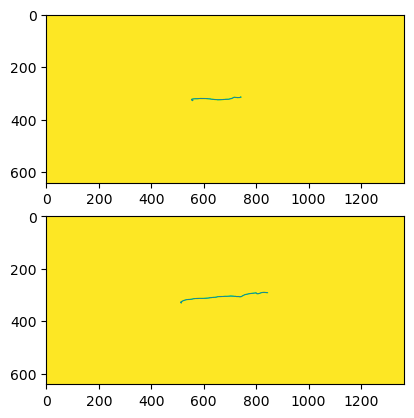

In [9]:
fig, axs = plt.subplots(2)
fig.set_facecolor("w")
axs[0].imshow(img1)
axs[1].imshow(img2)

# Shape descriptor

In [10]:
def shape_descriptor(contour):
    # Compute convex hull
    hull = cv2.convexHull(contour)

    # Check if hull is valid
    if len(hull) > 2:
        # Compute defects
        defects = cv2.convexityDefects(contour, hull)

        # Extract defects as an array of points
        points = []
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            start = tuple(contour[s][0])
            end = tuple(contour[e][0])
            far = tuple(contour[f][0])
            points.append((start, end, far))

        # Compute shape descriptor as a concatenation of the coordinates of the defects
        descriptor = np.concatenate([np.array(point).flatten() for point in points])
    else:
        # If hull is not valid, return an empty descriptor
        descriptor = np.array([])

    return descriptor

In [11]:
# Read in images
img1 = cv2.imread('C:\\Users\\koazg\\OneDrive\\Desktop\\FINALPROJ\\11031\\SimpleTest\\1.png', 0)
img2 = cv2.imread('C:\\Users\\koazg\\OneDrive\\Desktop\\FINALPROJ\\11030\\SimpleTest\\1.png', 0)
img1 = img1[219:860,:1365,:]
img2 = img2[219:860,:1365,:]

# Threshold images to create binary shapes
_, img1 = cv2.threshold(img1, 128, 255, cv2.THRESH_BINARY)
_, img2 = cv2.threshold(img2, 128, 255, cv2.THRESH_BINARY)

# Find contours in images
contours1, _ = cv2.findContours(img1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours2, _ = cv2.findContours(img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Compute shape descriptors for each shape
descriptor1 = shape_descriptor(contours1[0])
descriptor2 = shape_descriptor(contours2[0])

# Calculate Euclidean distance between shape descriptors as a measure of similarity
similarity = np.linalg.norm(descriptor1 - descriptor2)

print(f'Similarity: {similarity}')

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed